# 2D Sequential modular addition with a Quadratic RNN

To do:
- Should have an option to compute loss over all intermediate compositions (this will allow us to train for longer)
- Should create a dataloader that samples online
- Better activation plots


## Set up

In [1]:
# autoreload
%load_ext autoreload
%autoreload 2
# jupyter black formatter
%load_ext jupyter_black

import subprocess
import os
import sys

gitroot_path = subprocess.check_output(
    ["git", "rev-parse", "--show-toplevel"], universal_newlines=True
)

os.chdir(os.path.join(gitroot_path[:-1], "gagf"))
print("Working directory: ", os.getcwd())

sys_dir = os.path.dirname(os.getcwd())
sys.path.append(sys_dir)
print("Directory added to path: ", sys_dir)
sys.path.append(os.getcwd())
print("Directory added to path: ", os.getcwd())

Working directory:  /home/facosta/group-agf/gagf
Directory added to path:  /home/facosta/group-agf
Directory added to path:  /home/facosta/group-agf/gagf


## Imports

In [2]:
# Core
import numpy as np
import torch
import torch.nn as nn

# Torch utilities
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Vision
import torchvision
from torchvision import transforms

# Plotting
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.patches import Rectangle, Patch
from matplotlib.ticker import MaxNLocator
from matplotlib.lines import Line2D
from matplotlib.colors import Normalize
from matplotlib.colors import LogNorm
import matplotlib.cm as cm

# Misc
from tqdm import tqdm
from typing import Optional

## RNN Architecture

In [3]:
from gagf.rnns.model import QuadraticRNN

## Optimization

In [4]:
from gagf.rnns.train import train, test_accuracy

## Plotting functions

In [5]:
from gagf.rnns.utils import (
    style_axes,
    get_power_2d_adele,
    topk_template_freqs,
)

## 2D Dataset

In [6]:
from gagf.rnns.datamodule import (
    build_modular_addition_sequence_dataset_2d,
    mnist_template_2d,
    generate_template_unique_freqs,
)

## Experiment Setup

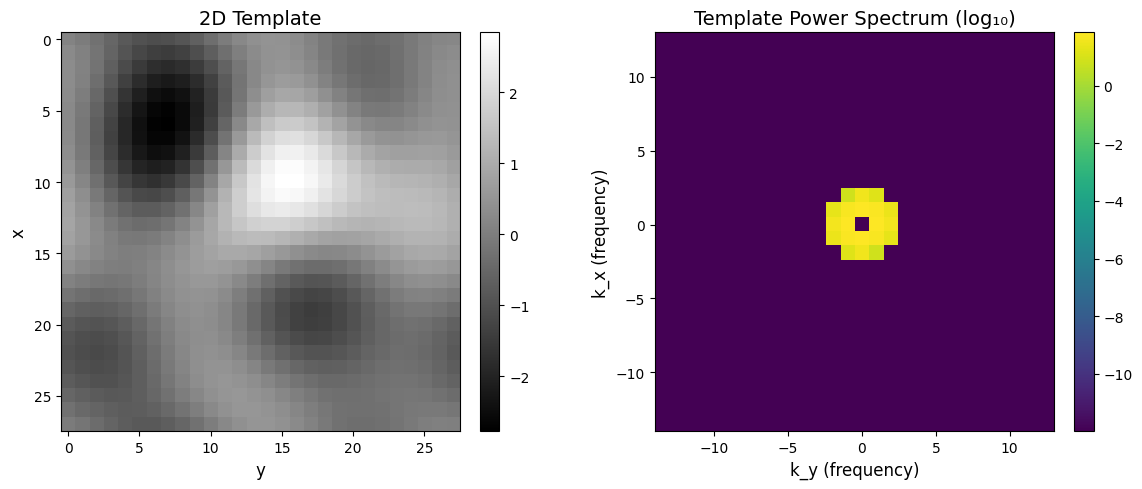

In [7]:
from gagf.rnns.utils import plot_2d_power_spectrum, plot_2d_signal, get_power_2d

# Set seed
np.random.seed(5)
torch.manual_seed(5)

# 2D dimensions
p1, p2 = 28, 28  # Can be different, but start with square
p_flat = p1 * p2

# Generate 2D template
template_2d = generate_template_unique_freqs(p1, p2, n_freqs=10)

# Mean center template
template_2d = template_2d - np.mean(template_2d)

# Visualize template and its spectrum
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
plot_2d_signal(axes[0], template_2d, title="2D Template", cmap="grey")
power_2d, fx, fy = get_power_2d(template_2d)
plot_2d_power_spectrum(axes[1], power_2d, fx, fy, title="Template Power Spectrum")
plt.tight_layout()
plt.show()

In [8]:
# Build sequence data
device = "cuda" if torch.cuda.is_available() else "cpu"
k = 3  # sequence length
mode = "sampled"
num_samples = 100000

X_seq_2d, Y_seq_2d, sequence_xy = build_modular_addition_sequence_dataset_2d(
    p1, p2, template_2d, k, mode=mode, num_samples=num_samples
)

# Convert to torch tensors
X_seq_2d_t = torch.tensor(X_seq_2d, dtype=torch.float32, device=device)
Y_seq_2d_t = torch.tensor(Y_seq_2d, dtype=torch.float32, device=device)

print(f"Dataset shapes:")
print(f"  X: {X_seq_2d_t.shape}  (N, k, p1*p2)")
print(f"  Y: {Y_seq_2d_t.shape}  (N, p1*p2)")
print(f"  Flattened dimension: {p_flat}")

Dataset shapes:
  X: torch.Size([100000, 3, 784])  (N, k, p1*p2)
  Y: torch.Size([100000, 784])  (N, p1*p2)
  Flattened dimension: 784


### Train 2D model

In [9]:
from gagf.rnns.main import main

In [10]:
config = {
    "data": {
        "p1": p1,
        "p2": p2,
        "k": k,
        "mode": mode,
        "num_samples": num_samples,
        "n_freqs": 10,
        "batch_size": 1000,
        "seed": 5,
    },
    "model": {
        "hidden_dim": 36,
        "init_scale": 1.0e-5,
    },
    "training": {
        "epochs": 5,
        "learning_rate": 0.0001,
        "weight_decay": 0.0,
        "betas": [0.9, 0.999],
        "grad_clip": 0.1,
        "verbose_interval": 5,
    },
    "device": "cuda",
}

In [11]:
main(config)

Experiment directory: runs/20251027_100715
Using device: cuda
Generating data...
  X: torch.Size([100000, 3, 784]), Y: torch.Size([100000, 784])
Setting up model and training...
Training for 5 epochs...
[RNN] Epoch 5/5 | loss 1.000000 | acc 0.12%
Saving results to runs/20251027_100715...
  ✓ All results saved
Plotting training loss...
  ✓ Saved loss plot to runs/20251027_100715/training_loss.pdf
Plotting model predictions over time...
  ✓ Saved predictions plot to runs/20251027_100715/predictions_over_time.pdf
Training complete!
  Final loss: 1.000000
  Final accuracy: 0.12%
  Training time: 7.69s


(QuadraticRNN(),
 [0.9999999403953552,
  0.9999999397993088,
  0.9999999403953552,
  0.9999999386072159,
  0.9999999409914017,
  0.9999999397993088],
 [0.116, 0.11, 0.115, 0.114, 0.113, 0.118],
 [{'W_in': tensor([[ 6.5797e-07,  1.8532e-07, -6.1140e-07,  ...,  6.3257e-07,
            -6.2770e-08, -1.8367e-08],
           [ 5.4173e-08,  1.7025e-08,  4.3758e-07,  ...,  3.9975e-07,
             4.8185e-07,  4.8165e-07],
           [ 3.3109e-07,  2.4579e-07,  1.4045e-07,  ..., -6.4122e-07,
            -2.7117e-07, -2.7401e-07],
           ...,
           [-1.5307e-07, -3.7666e-07,  3.1178e-07,  ..., -2.1770e-07,
             6.7906e-07, -1.2324e-07],
           [ 2.4522e-07, -1.6872e-07,  4.4785e-07,  ...,  3.3524e-07,
             5.3272e-08, -3.2938e-07],
           [-6.3873e-08,  1.4652e-08,  9.5008e-07,  ...,  2.3405e-08,
            -3.3868e-07,  3.7979e-07]]),
   'W_mix': tensor([[ 1.7053e-06, -1.2593e-06, -2.8932e-06,  ...,  1.5234e-06,
             1.6407e-06, -1.7395e-06],
        

In [13]:
from gagf.rnns.train import train

batch_size = 1000
seq_dataset_2d = TensorDataset(X_seq_2d_t, Y_seq_2d_t)
seq_loader_2d = DataLoader(
    seq_dataset_2d, batch_size=batch_size, shuffle=True, drop_last=False
)

# Model - note p is now p1*p2
template_torch = torch.tensor(template_2d, device=device, dtype=torch.float32).flatten()
hidden_dim_2d = 36  # Scale up for larger input dimension
rnn_2d = QuadraticRNN(
    p=p_flat,
    d=hidden_dim_2d,
    template=template_torch,
    init_scale=1e-5,
).to(device)

criterion = nn.MSELoss()

weight_decay = 0  # relevant for W_mix plot
learning_rate = 0.0001

optimizer = optim.Adam(
    rnn_2d.parameters(), lr=learning_rate, betas=(0.9, 0.999), weight_decay=weight_decay
)

epochs = 5

loss_hist_2d, acc_hist_2d, param_hist_2d = train(
    rnn_2d,
    seq_loader_2d,
    criterion,
    optimizer,
    epochs=epochs,
    verbose_interval=5,
    grad_clip=0.1,
)

[RNN] Epoch 5/5 | loss 1.000000 | acc 0.15%


## Loss Plot

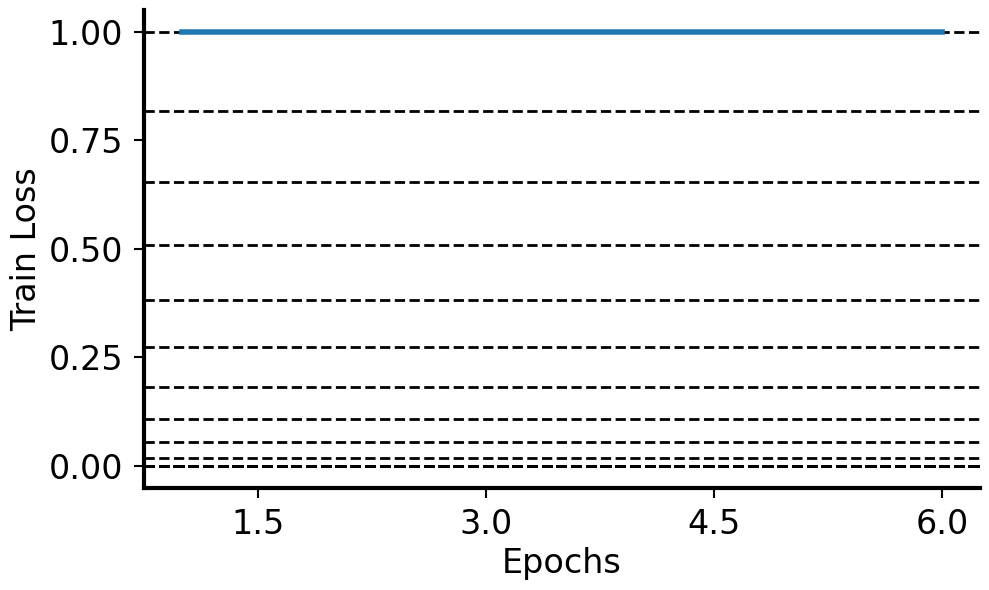

In [14]:
# --- Plot RNN training loss only ---
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# x-axis = epochs 1..T
x = np.arange(1, len(loss_hist_2d) + 1)
ax.plot(x, loss_hist_2d, lw=4)

# === Compute power spectrum of template ===
x_freq, y_freq, power = get_power_2d_adele(template_2d)
power = power.flatten()
valid = power > 1e-20
power = power[valid]
sorted_idx = np.argsort(power)[::-1]  # np.argsort with [::-1] gives descending order
power = power[sorted_idx]
# print("Power in x: {}".format(power))

# Plot theoretical lines
alpha_values = [np.sum(power[k:]) for k in range(len(power))]
coef = 1 / (p1 * p2)
for k, alpha in enumerate(alpha_values):
    ax.axhline(y=coef * alpha, color="black", linestyle="--", linewidth=2, zorder=-2)


# # Steps
# steps = [1, 20, 50, len(param_hist) - 1]  # make sure these are < len(rnn_param_hist)
# for step in steps:
#     ax.axvline(step, c="k")

# plot in log scale
# ax.set_xscale("log")
# ax.set_yscale("log")
# ax.set_ylim(3.5e-2, 1.3e-1)

ax.set_xlabel("Epochs", fontsize=24)
ax.set_ylabel("Train Loss", fontsize=24)

style_axes(ax)

plt.grid(False)
plt.tight_layout()
# plt.savefig("rnn-loss.pdf", bbox_inches="tight")
plt.show()

## Prediction Plot

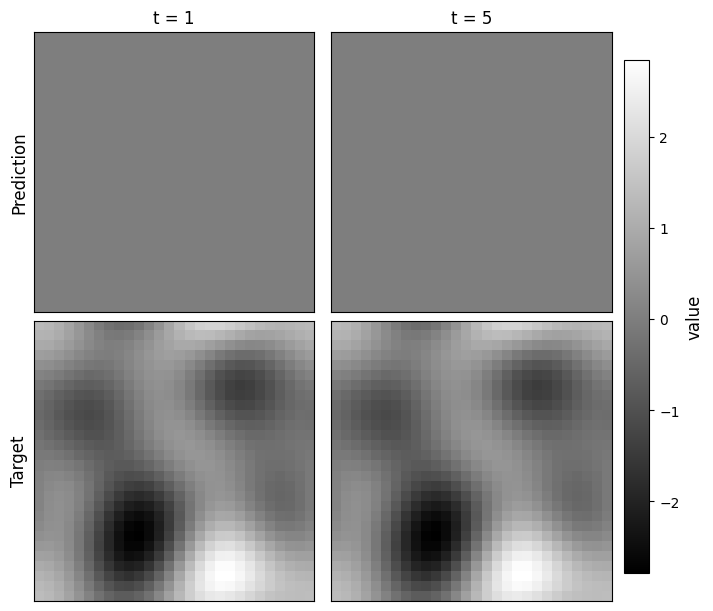

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import torch

# --- config ---
steps_2d = [1, 5]  # , 10, len(param_hist_2d) - 1]
example_idx = int(np.random.randint(len(Y_seq_2d_t)))
cmap = "gray"
origin = "upper"  # use "lower" if you prefer cartesian orientation

device = next(rnn_2d.parameters()).device
rnn_2d.to(device).eval()

# --- collect preds for the SAME example across steps ---
preds = []
with torch.no_grad():
    truth_2d = Y_seq_2d_t[example_idx].reshape(p1, p2).cpu().numpy()

for step in steps_2d:
    rnn_2d.load_state_dict(param_hist_2d[step], strict=True)
    with torch.no_grad():
        x = X_seq_2d_t[example_idx : example_idx + 1].to(device)  # (1, k, p1*p2)
        pred_2d = rnn_2d(x).reshape(p1, p2).detach().cpu().numpy()
        preds.append(pred_2d)

# --- shared color scale ---
vmin = np.min(truth_2d)  # min(np.min(truth_2d), *(np.min(p) for p in preds))
vmax = np.max(truth_2d)  # max(np.max(truth_2d), *(np.max(p) for p in preds))

# --- plot: rows = [Prediction, Target], cols = time steps ---
fig, axes = plt.subplots(
    2, len(steps_2d), figsize=(3.5 * len(steps_2d), 6), layout="constrained"
)

for col, (step, pred_2d) in enumerate(zip(steps_2d, preds)):
    im = axes[0, col].imshow(pred_2d, vmin=vmin, vmax=vmax, cmap=cmap, origin=origin)
    axes[0, col].set_title(f"t = {step}", fontsize=12)
    axes[0, col].set_xticks([])
    axes[0, col].set_yticks([])

    axes[1, col].imshow(truth_2d, vmin=vmin, vmax=vmax, cmap=cmap, origin=origin)
    axes[1, col].set_xticks([])
    axes[1, col].set_yticks([])

axes[0, 0].set_ylabel("Prediction", fontsize=12)
axes[1, 0].set_ylabel("Target", fontsize=12)

# single shared colorbar on the right
fig.colorbar(im, ax=axes, location="right", shrink=0.9, pad=0.02).set_label(
    "value", fontsize=12
)

plt.show()

## Prediction Power Spectrum Plot

In [21]:
## 2D Power Spectrum Over Time (top-K template freqs)

# --- how many frequencies to track (includes DC if it ranks in top-K) ---
num_freqs_to_track = 10  # change as you like

# --- pick top-K frequencies from the template's 2D power (non-redundant half-plane) ---
template_power_2d, _, _ = get_power_2d(template_2d)  # shape (p1, p2)
tracked_freqs = topk_template_freqs(template_2d, K=num_freqs_to_track)
target_powers = {(kx, ky): template_power_2d[kx, ky] for (kx, ky) in tracked_freqs}

# --- choose analysis steps (log-spaced) ---
num_points = 100
num_samples = 100
T = len(param_hist_2d)
steps_2d_analysis = np.unique(
    np.logspace(0, np.log10(max(T - 1, 1)), num_points, dtype=int)
)
steps_2d_analysis = steps_2d_analysis[steps_2d_analysis < T]
steps_2d_analysis = np.insert(steps_2d_analysis, 0, 0)

# --- track average output power at those frequencies over training ---
powers_over_time_2d = {freq: [] for freq in tracked_freqs}

with torch.no_grad():
    for step in tqdm(steps_2d_analysis, desc="Computing power spectra"):
        rnn_2d.load_state_dict(param_hist_2d[step], strict=True)
        rnn_2d.eval()

        outputs_flat = (
            rnn_2d(X_seq_2d_t[:num_samples].to(device)).detach().cpu().numpy()
        )  # (N, p1*p2)

        # average power over batch
        # (simple loop for clarity; vectorize later if needed)
        powers_batch = []
        for i in range(outputs_flat.shape[0]):
            out_2d = outputs_flat[i].reshape(p1, p2)
            power_i, _, _ = get_power_2d(out_2d)  # (p1, p2)
            powers_batch.append(power_i)
        avg_power = np.mean(powers_batch, axis=0)  # (p1, p2)

        for kx, ky in tracked_freqs:
            powers_over_time_2d[(kx, ky)].append(avg_power[kx, ky])

# --- convert lists to arrays ---
for freq in tracked_freqs:
    powers_over_time_2d[freq] = np.array(powers_over_time_2d[freq])

Computing power spectra:   0%|          | 0/6 [00:00<?, ?it/s]

Computing power spectra: 100%|██████████| 6/6 [00:00<00:00, 240.37it/s]


## Plot prediction power spectrum over time

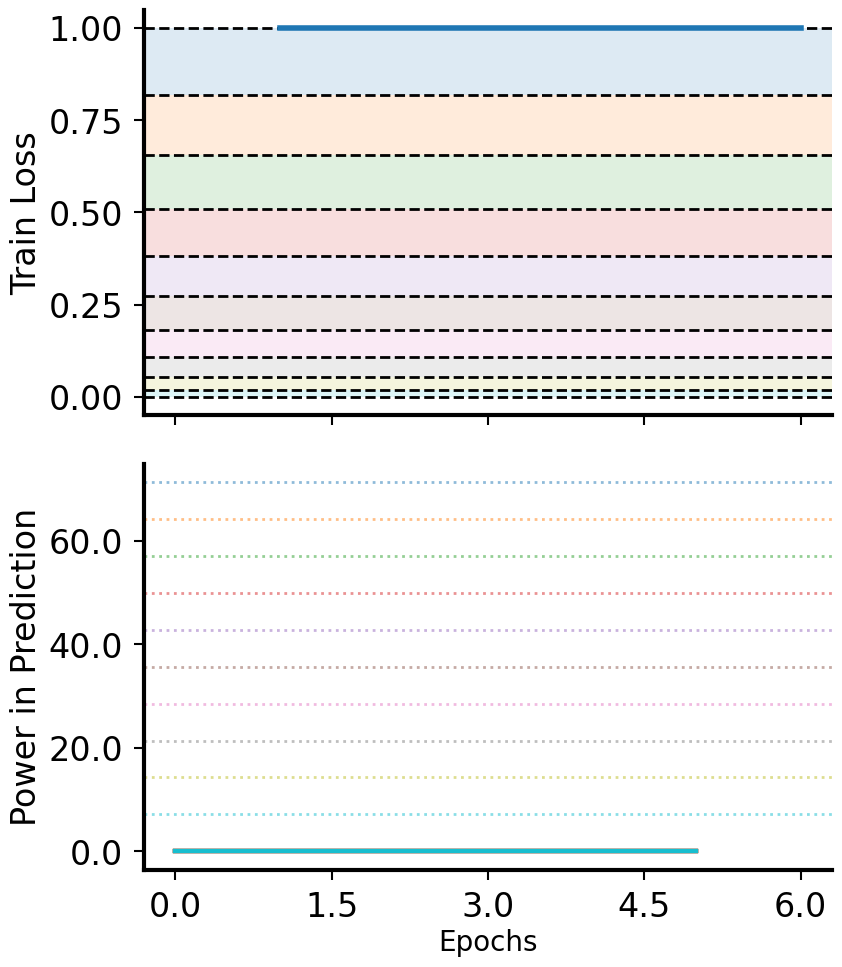

In [22]:
from matplotlib.ticker import FormatStrFormatter

# Colors used for both the bands (top) and the mode curves (bottom)
colors_2d = plt.cm.tab10(np.linspace(0, 1, len(tracked_freqs)))

# Make the figure a bit shorter and reduce vertical gap between plots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 10), sharex=True)
fig.subplots_adjust(left=0.12, right=0.98, top=0.96, bottom=0.10, hspace=0.12)

# ---------------- Top: training loss + theory lines ----------------
x = np.arange(1, len(loss_hist_2d) + 1)
ax1.plot(x, loss_hist_2d, lw=4, zorder=5)

# Compute power spectrum of template for theory lines
fy, fx, power = get_power_2d_adele(template_2d)  # adapt unpacking if your func differs
power_flat = np.sort(power.flatten()[power.flatten() > 1e-20])[::-1]

# Theory levels (cumulative tail sums)
alpha_values = np.array([np.sum(power_flat[k:]) for k in range(len(power_flat))])
coef = 1.0 / (p1 * p2)
y_levels = coef * alpha_values  # strictly decreasing

# Shade horizontal bands between successive theory lines
n_bands = min(len(tracked_freqs), len(y_levels) - 1)
for i in range(n_bands):
    y_top = y_levels[i]
    y_bot = y_levels[i + 1]
    ax1.axhspan(y_bot, y_top, facecolor=colors_2d[i], alpha=0.15, zorder=-3)

# Draw the black theory lines
for y in y_levels[: n_bands + 1]:
    ax1.axhline(y=y, color="black", linestyle="--", linewidth=2, zorder=-2)

# ax1.set_ylim(3.5e-2, 1.3e-1)
ax1.set_ylabel("Train Loss", fontsize=24)
style_axes(ax1)
ax1.grid(False)
ax1.tick_params(labelbottom=False)  # only show x ticks on bottom plot

# ---------------- Bottom: tracked mode power over time ----------------
for i, (kx, ky) in enumerate(tracked_freqs):
    ax2.plot(steps_2d_analysis, powers_over_time_2d[(kx, ky)], color=colors_2d[i], lw=3)
    ax2.axhline(
        target_powers[(kx, ky)],
        color=colors_2d[i],
        linestyle="dotted",
        linewidth=2,
        alpha=0.5,
    )

ax2.set_xlabel("Epochs", fontsize=20)
ax2.set_ylabel("Power in Prediction", fontsize=24)
ax2.grid(True, alpha=0.3)
style_axes(ax2)
ax2.yaxis.set_major_formatter(FormatStrFormatter("%.1f"))

# No legend; plots are closer via reduced hspace and smaller figure height
plt.savefig("train-loss.pdf", bbox_inches="tight")
plt.show()

## Plot reference Fourier modes (irreps of G)

In [23]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe

# Expected to exist:
# - tracked_freqs : list[tuple[int,int]]
# - p1, p2        : ints

# Colors
try:
    colors_2d
except NameError:
    colors_2d = plt.cm.tab10(np.linspace(0, 1, len(tracked_freqs)))


def fourier_mode_2d(p1: int, p2: int, kx: int, ky: int, phase: float = 0.0):
    y = np.arange(p1)[:, None]
    x = np.arange(p2)[None, :]
    mode = np.cos(2 * np.pi * (ky * y / p1 + kx * x / p2) + phase)
    mmin, mmax = mode.min(), mode.max()
    return (mode - mmin) / (mmax - mmin) if mmax > mmin else mode


def signed_k(k: int, n: int) -> int:
    return k if k <= n // 2 else k - n


def pretty_k(k: int, n: int) -> str:
    if n % 2 == 0 and k == n // 2:
        return r"\pm{}".format(n // 2)
    return f"{signed_k(k, n)}"


# ---- Save each mode separately ----
out_dir = "fourier_modes"
os.makedirs(out_dir, exist_ok=True)

for i, (kx, ky) in enumerate(tracked_freqs):
    img = fourier_mode_2d(p1, p2, kx, ky)

    fig, ax = plt.subplots(figsize=(3.2, 2.2))
    ax.imshow(img, cmap="RdBu_r", origin="upper")
    ax.set_xticks([])
    ax.set_yticks([])

    # Colored border
    for side in ("left", "right", "top", "bottom"):
        ax.spines[side].set_edgecolor(colors_2d[i])
        ax.spines[side].set_linewidth(8)

    # Big, colored, centered label
    kx_label = pretty_k(kx, p2)
    ky_label = pretty_k(ky, p1)
    ax.text(
        0.5,
        0.5,
        f"$k=({kx_label},{ky_label})$",
        color=colors_2d[i],
        fontsize=25,
        fontweight="bold",
        ha="center",
        va="center",
        transform=ax.transAxes,
        path_effects=[pe.withStroke(linewidth=3, foreground="white", alpha=0.8)],
    )

    plt.tight_layout()

    # Filenames include both raw and signed indices
    kx_signed, ky_signed = signed_k(kx, p2), signed_k(ky, p1)
    base = f"mode_{i:03d}_kx{kx}_ky{ky}_signed_{kx_signed}_{ky_signed}"
    png_path = os.path.join(out_dir, base + ".png")
    npy_path = os.path.join(out_dir, base + ".npy")

    fig.savefig(png_path, dpi=300, bbox_inches="tight")
    plt.close(fig)

    # Optional: save the normalized array too
    np.save(npy_path, img)

print(f"Saved {len(tracked_freqs)} mode images (and .npy arrays) to: {out_dir}/")

Saved 10 mode images (and .npy arrays) to: fourier_modes/


In [264]:
# ---- Save one tall, vertically stacked image (labels on RIGHT) with extra whitespace
#      and safe padding so thick borders aren't trimmed ----
stack_name = "fourier_modes_stacked_rightlabel_spaced.png"  # or ".pdf"
stack_path = os.path.join(out_dir, stack_name)

n = len(tracked_freqs)

# Panel geometry and gap (increase gap_h_in for more whitespace)
panel_h_in = 2.2
gap_h_in   = 0.35   # whitespace between rows
# total width = image col + label col
fig_w_in   = 4.6
fig_h_in   = n * panel_h_in + (n - 1) * gap_h_in

import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(fig_w_in, fig_h_in), dpi=300)

# Rows alternate: [panel, gap, panel, gap, ..., panel]
rows = 2 * n - 1
height_ratios = []
for i in range(n):
    height_ratios.append(panel_h_in)
    if i < n - 1:
        height_ratios.append(gap_h_in)

# Right-labeled: image on LEFT, label on RIGHT
gs = gridspec.GridSpec(
    nrows=rows, ncols=2,
    width_ratios=[1.0, 0.46],   # image : label (bump right col if labels are long)
    height_ratios=height_ratios,
    wspace=0.0, hspace=0.0
)

for i, (kx, ky) in enumerate(tracked_freqs):
    r = 2 * i  # even rows are content; odd rows are spacers

    # Image axis (left)
    ax_img = fig.add_subplot(gs[r, 0])
    img = fourier_mode_2d(p1, p2, kx, ky)
    ax_img.imshow(img, cmap="RdBu_r", origin="upper", aspect="equal")
    ax_img.set_xticks([]); ax_img.set_yticks([])

    # Colored border around the image only
    for side in ("left", "right", "top", "bottom"):
        ax_img.spines[side].set_edgecolor(colors_2d[i])
        ax_img.spines[side].set_linewidth(8)

    # Label axis (right)
    ax_label = fig.add_subplot(gs[r, 1])
    ax_label.set_axis_off()
    kx_label = pretty_k(kx, p2)
    ky_label = pretty_k(ky, p1)
    ax_label.text(
        0.0, 0.5, f"$k=({kx_label},{ky_label})$",
        color=colors_2d[i], fontsize=45, fontweight="bold",
        ha="left", va="center", transform=ax_label.transAxes,
        path_effects=[pe.withStroke(linewidth=3, foreground="white", alpha=0.8)]
    )

# Pull content slightly in from the canvas edges so spines aren't flush
fig.subplots_adjust(left=0.02, right=0.98, top=0.985, bottom=0.015)

# Save with a tiny pad so thick borders aren't clipped by 'tight' bbox
fig.savefig(stack_path, dpi=300, bbox_inches="tight", pad_inches=0.12)
plt.close(fig)

print(f"Saved vertical stack with RIGHT labels and spacing (no edge clipping): {stack_path}")

Saved vertical stack with RIGHT labels and spacing (no edge clipping): fourier_modes/fourier_modes_stacked_rightlabel_spaced.png


## W_out Plot

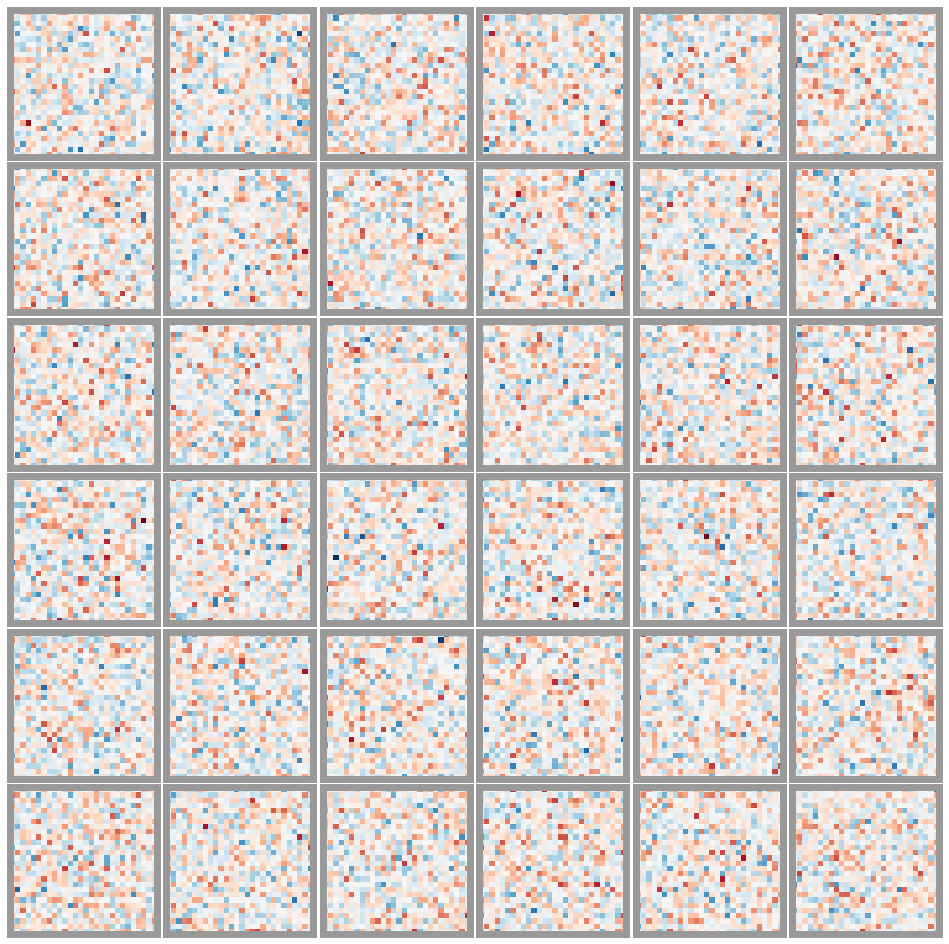

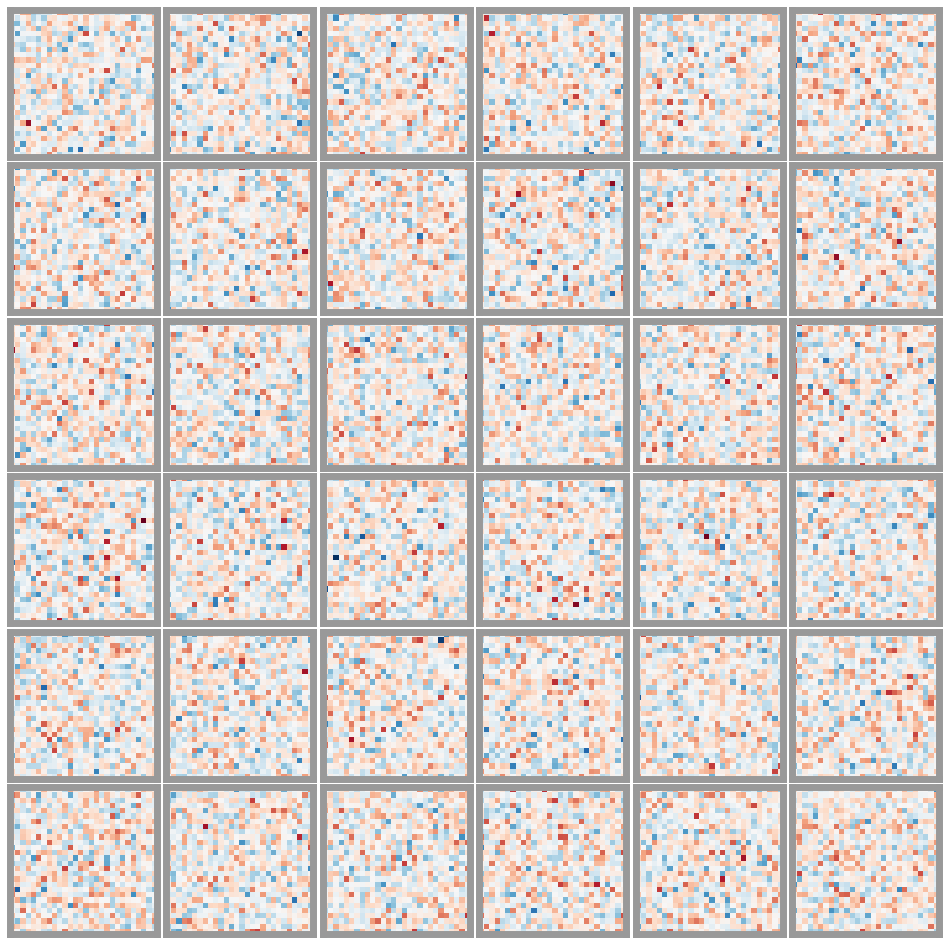

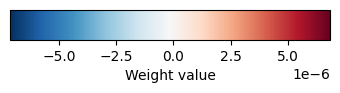

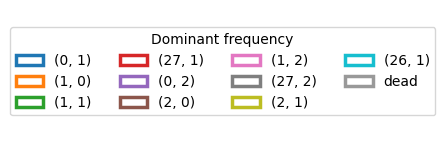

In [26]:
# ========= Inputs you already have =========
# param_hist_2d : list of state-dicts with key "W_out"
# p1, p2        : reshape dims (p1 * p2 == D)

# ========= Config =========
steps_2d = [1, 5]  # 100, len(param_hist_2d) - 1]
dead_thresh_l2 = 0.25  # absolute L2-norm threshold for "dead" neurons
heat_cmap = "RdBu_r"  # colormap for heatmaps (weight values)
border_lw = 5.0  # border width for neuron tiles
title_fs = 18  # suptitle font size

# Colors for categories
palette = plt.cm.tab10(np.linspace(0, 1, len(tracked_freqs)))
dead_color = (0.6, 0.6, 0.6, 1.0)


# ========= Tiny helpers =========
def squareish_grid(n):
    c = int(np.ceil(np.sqrt(n)))
    r = int(np.ceil(n / c))
    return r, c


def tracked_power_from_fft2(power2d, kx, ky, p1, p2):
    """Sum power at (kx,ky) and its real-signal mirror (-kx,-ky)."""
    i0, j0 = kx % p1, ky % p2
    i1, j1 = (-kx) % p1, (-ky) % p2
    if (i0, j0) == (i1, j1):
        return power2d[i0, j0]
    return power2d[i0, j0] + power2d[i1, j1]


# ========= Prep: sizes and global color limits =========
W0 = param_hist_2d[steps_2d[0]]["W_out"].detach().cpu().numpy().T  # (H, D)
H, D = W0.shape
assert p1 * p2 == D, f"p1*p2 ({p1*p2}) must equal D ({D})."

vmin, vmax = np.inf, -np.inf
for step in steps_2d:
    W = param_hist_2d[step]["W_out"].detach().cpu().numpy().T
    vmin = min(vmin, W.min())
    vmax = max(vmax, W.max())

# ========= One figure per time step =========
R_ner, C_ner = squareish_grid(H)
tile_w, tile_h = 2, 2  # inches per neuron tile
figsize = (C_ner * tile_w, R_ner * tile_h)

for step in steps_2d:
    W = param_hist_2d[step]["W_out"].detach().cpu().numpy().T  # (H, D)

    # Dominant tracked frequency + dead mask
    dom_idx = np.empty(H, dtype=int)
    l2 = np.linalg.norm(W, axis=1)
    dead_mask = l2 < dead_thresh_l2

    for j in range(H):
        m = W[j].reshape(p1, p2)
        F = np.fft.fft2(m)
        P = (F.conj() * F).real
        tp = [tracked_power_from_fft2(P, kx, ky, p1, p2) for (kx, ky) in tracked_freqs]
        dom_idx[j] = int(np.argmax(tp))

    edge_colors = palette[dom_idx]
    edge_colors[dead_mask] = dead_color

    # Build figure for this time step
    fig = plt.figure(figsize=figsize)
    # fig.suptitle(f"step {step}", fontsize=title_fs, fontweight="bold", y=0.98)
    gs = gridspec.GridSpec(R_ner, C_ner, figure=fig, wspace=0.06, hspace=0.06)

    # Plot tiles
    for j in range(R_ner * C_ner):
        ax = fig.add_subplot(gs[j // C_ner, j % C_ner])
        if j < H:
            m = W[j].reshape(p1, p2)
            im = ax.imshow(
                m, vmin=vmin, vmax=vmax, origin="lower", aspect="equal", cmap=heat_cmap
            )
            # border highlight
            ec = edge_colors[j]
            for sp in ax.spines.values():
                sp.set_edgecolor(ec)
                sp.set_linewidth(border_lw)
        else:
            ax.axis("off")

        ax.set_xticks([])
        ax.set_yticks([])
    plt.savefig(f"step {step}", bbox_inches="tight", dpi=200)
    plt.show()

# ========= Standalone GLOBAL COLORBAR figure =========
fig_cb = plt.figure(figsize=(4, 1.0))  # wide short bar
ax_cb = fig_cb.add_axes([0.1, 0.35, 0.8, 0.3])  # [left, bottom, width, height]
norm = Normalize(vmin=vmin, vmax=vmax)
sm = cm.ScalarMappable(norm=norm, cmap=heat_cmap)
cbar = fig_cb.colorbar(sm, cax=ax_cb, orientation="horizontal")
cbar.set_label("Weight value")
plt.show()

# ========= Standalone LEGEND figure for dominant frequency =========
fig_legend = plt.figure(figsize=(5, 1.6))
ax_leg = fig_legend.add_subplot(111)
ax_leg.axis("off")

# Use patches with COLORED EDGES (to match tile borders)
handles = [
    Patch(
        facecolor="white", edgecolor=palette[i], linewidth=2.5, label=tracked_freqs[i]
    )
    for i in range(len(tracked_freqs))
]
handles.append(
    Patch(facecolor="white", edgecolor=dead_color, linewidth=2.5, label="dead")
)

leg = ax_leg.legend(
    handles=handles, ncol=4, frameon=True, loc="center", title="Dominant frequency"
)
plt.show()

## W_mix Plot

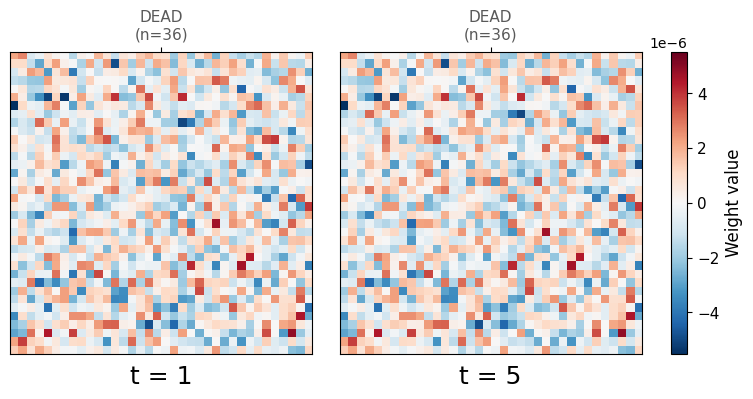

In [27]:
# =========================
# Config
# =========================
within_group_order = "phase"  # 'phase' | 'power' | 'phase_power' | 'none'
outfile = "Wmix_grouped_by_Wo_freq_labeled.pdf"
cmap = "RdBu_r"

TITLE_FONTSIZE = 18
LABEL_FONTSIZE = 11
CBAR_LABEL_SIZE = 12
CBAR_TICK_SIZE = 11
SEPARATOR_LW = 0.9
BLOCK_EDGE_LW = 2.0

dead_l2_thresh = 0.1
dead_position = "last"

# how many template freqs to track/label
num_freqs_to_track = 7  # e.g., like your old list length

# You must have template_2d (shape p1 x p2) defined.
p1, p2 = template_2d.shape


# =========================
# Helpers (2D, top-K tracked)
# =========================
def topk_template_freqs(template_2d: np.ndarray, K: int, min_power: float = 1e-20):
    # Use your get_power_2d_adele(template_2d) -> (freqs_u, freqs_v, power)
    freqs_u, freqs_v, power = get_power_2d_adele(
        template_2d
    )  # power: (p1, p2//2+1) or similar
    shp = power.shape
    flat = power.ravel()
    mask = flat > min_power
    if not np.any(mask):
        return []
    top_idx = np.flatnonzero(mask)[np.argsort(flat[mask])[::-1]][:K]
    kx, ky = np.unravel_index(top_idx, shp)
    return list(zip(kx.tolist(), ky.tolist()))


def tracked_power_from_fft2(power2d, kx, ky, p1, p2):
    i0, j0 = kx % p1, ky % p2
    i1, j1 = (-kx) % p1, (-ky) % p2
    if (i0, j0) == (i1, j1):
        return float(power2d[i0, j0])
    return float(power2d[i0, j0] + power2d[i1, j1])


def analyze_Wo_tracked(sd, tracked_freqs, p1, p2):
    """
    For each neuron row of W_o, find the dominant freq among tracked_freqs.
    Returns:
      dom_idx (index into tracked_freqs), phase (at rep bin), dom_power, l2, D
    """
    Wo = sd["W_out"].detach().cpu().numpy()  # (p, H) with p = p1*p2
    W = Wo.T  # (H, p)
    H, D = W.shape
    assert D == p1 * p2

    dom_idx = np.empty(H, dtype=int)
    dom_pow = np.empty(H, dtype=float)
    phase = np.empty(H, dtype=float)
    l2 = np.linalg.norm(W, axis=1)

    for j in range(H):
        m = W[j].reshape(p1, p2)
        F = np.fft.fft2(m)
        P = (F.conj() * F).real
        # power only at tracked bins (with symmetry accounted)
        tp = [tracked_power_from_fft2(P, kx, ky, p1, p2) for (kx, ky) in tracked_freqs]
        jj = int(np.argmax(tp))
        dom_idx[j] = jj
        # phase at representative positive bin
        i0, j0 = tracked_freqs[jj][0] % p1, tracked_freqs[jj][1] % p2
        phase[j] = np.angle(F[i0, j0])
        dom_pow[j] = tp[jj]
    return dom_idx, phase, dom_pow, l2, D


def permutation_from_groups_with_dead(
    dom_idx,
    phase,
    dom_power,
    l2,
    *,
    within="phase",
    dead_l2_thresh=1e-1,
    dead_position="last",
):
    dead_mask = l2 < float(dead_l2_thresh)
    groups = {}
    for i, f in enumerate(dom_idx):
        key = -1 if dead_mask[i] else int(f)  # f is index into tracked_freqs
        groups.setdefault(key, []).append(i)

    freq_keys = sorted([k for k in groups.keys() if k >= 0])
    ordered_keys = (freq_keys + [-1]) if dead_position == "last" else ([-1] + freq_keys)
    group_keys = [k for k in ordered_keys if k in groups]

    perm, boundaries = [], []
    for f in group_keys:
        idxs = groups[f]
        if f == -1:
            idxs = sorted(idxs, key=lambda i: l2[i])
        else:
            if within == "phase" and phase is not None:
                idxs = sorted(idxs, key=lambda i: (phase[i] + 2 * np.pi) % (2 * np.pi))
            elif within == "power" and dom_power is not None:
                idxs = sorted(idxs, key=lambda i: -dom_power[i])
            elif (
                within == "phase_power" and phase is not None and dom_power is not None
            ):
                idxs = sorted(
                    idxs,
                    key=lambda i: ((phase[i] + 2 * np.pi) % (2 * np.pi), -dom_power[i]),
                )
        perm.extend(idxs)
        boundaries.append(len(perm))
    return np.array(perm, dtype=int), group_keys, boundaries


def reorder_square(M, perm):
    return M[perm][:, perm]


# labels & colors for the tracked list
tracked_freqs = topk_template_freqs(template_2d, num_freqs_to_track)
tracked_labels = [
    ("DC" if (kx, ky) == (0, 0) else f"({kx},{ky})") for (kx, ky) in tracked_freqs
]


def build_freq_colors_tracked(n):
    return plt.cm.tab10(np.linspace(0, 1, n))


freq_colors = build_freq_colors_tracked(len(tracked_freqs))
dead_gray = "0.35"


def add_group_labels_top(
    ax, group_keys, boundaries, *, show_counts=True, rotation=0, fontsize=LABEL_FONTSIZE
):
    starts = [0] + boundaries[:-1]
    ends = [b - 1 for b in boundaries]
    centers = [(s + e) / 2.0 for s, e in zip(starts, ends)]
    sizes = [e - s + 1 for s, e in zip(starts, ends)]

    labels = []
    colors = []
    for kk, nn in zip(group_keys, sizes):
        if kk == -1:
            base = "DEAD"
            clr = dead_gray
        else:
            base = tracked_labels[kk]
            clr = freq_colors[kk]
        labels.append(f"{base}\n(n={nn})" if show_counts else base)
        colors.append(clr)

    ax.set_xticks(centers)
    ax.set_xticklabels(labels, rotation=rotation, fontsize=fontsize, ha="center")
    ax.tick_params(
        axis="x",
        bottom=False,
        top=True,
        labelbottom=False,
        labeltop=True,
        labelsize=fontsize,
    )
    for lbl, clr in zip(ax.get_xticklabels(), colors):
        lbl.set_color(clr)


# =========================
# Prepare steps & snapshots
# =========================
steps = [1, 5]  # [50, 100, len(param_hist_2d) - 1]
Wh_perm_list = []
group_info_list = []

for s in steps:
    sd = param_hist_2d[s]

    # analyze W_o against tracked 2D freqs
    dom_idx, phase, dom_power, l2, D = analyze_Wo_tracked(sd, tracked_freqs, p1, p2)

    # W_mix fallback to W_h
    if "W_mix" in sd:
        M = sd["W_mix"].detach().cpu().numpy()
    elif "W_h" in sd:
        M = sd["W_h"].detach().cpu().numpy()
    else:
        raise KeyError("Neither 'W_mix' nor 'W_h' found in state dict.")

    perm, group_keys, boundaries = permutation_from_groups_with_dead(
        dom_idx,
        phase,
        dom_power,
        l2,
        within=within_group_order,
        dead_l2_thresh=dead_l2_thresh,
        dead_position=dead_position,
    )

    M_perm = reorder_square(M, perm)
    Wh_perm_list.append(M_perm)
    group_info_list.append((group_keys, boundaries))

# Shared symmetric color limits
vmax = max(np.max(np.abs(M)) for M in Wh_perm_list)
vmin = -vmax if vmax > 0 else 0.0

# =========================
# Plot
# =========================
n = len(steps)
fig, axes = plt.subplots(1, n, figsize=(3.8 * n, 3.8), constrained_layout=True)
try:
    fig.set_constrained_layout_pads(
        w_pad=0.003, h_pad=0.003, wspace=0.003, hspace=0.003
    )
except Exception:
    pass
if n == 1:
    axes = [axes]

im = None
for j, (s, M_perm) in enumerate(zip(steps, Wh_perm_list)):
    ax = axes[j]
    im = ax.imshow(
        M_perm, cmap=cmap, vmin=vmin, vmax=vmax, aspect="equal", interpolation="nearest"
    )

    ax.set_yticks([])
    ax.tick_params(axis="x", bottom=False)

    group_keys, boundaries = group_info_list[j]
    for b in boundaries[:-1]:
        ax.axhline(b - 0.5, color="k", lw=SEPARATOR_LW, alpha=0.65)
        ax.axvline(b - 0.5, color="k", lw=SEPARATOR_LW, alpha=0.65)

    starts = [0] + boundaries[:-1]
    ends = [b - 1 for b in boundaries]
    for kk, s0, e0 in zip(group_keys, starts, ends):
        if kk == -1:  # skip DEAD box color
            continue
        size = e0 - s0 + 1
        rect = Rectangle(
            (s0 - 0.5, s0 - 0.5),
            width=size,
            height=size,
            fill=False,
            linewidth=BLOCK_EDGE_LW,
            edgecolor=freq_colors[kk],
            alpha=0.95,
            joinstyle="miter",
        )
        ax.add_patch(rect)

    add_group_labels_top(
        ax,
        group_keys,
        boundaries,
        show_counts=True,
        rotation=0,
        fontsize=LABEL_FONTSIZE,
    )
    ax.set_xlabel(f"t = {s}", fontsize=TITLE_FONTSIZE, labelpad=8)

# shared colorbar
cbar = fig.colorbar(im, ax=axes, shrink=1.0, pad=0.012, aspect=18)
cbar.ax.tick_params(labelsize=CBAR_TICK_SIZE)
cbar.set_label("Weight value", fontsize=CBAR_LABEL_SIZE)

plt.savefig(outfile, bbox_inches="tight", dpi=200)
plt.show()

In [28]:
# =========================
# Save tight heatmaps (keep separators + rectangles; no labels/legend)
# =========================
import os
from matplotlib.patches import Rectangle

base, ext = os.path.splitext(outfile)
if not ext:
    ext = ".png"  # change to ".pdf" if preferred

# Shared symmetric color limits across steps
vmax = max(np.max(np.abs(M)) for M in Wh_perm_list)
vmin = -vmax if vmax > 0 else 0.0

for j, (s, M_perm) in enumerate(zip(steps, Wh_perm_list)):
    # Full-bleed figure (no margins)
    fig = plt.figure(figsize=(3.2, 3.2), dpi=200)
    ax = plt.Axes(fig, [0, 0, 1, 1])  # left, bottom, width, height (normalized)
    fig.add_axes(ax)
    ax.set_axis_off()  # no ticks/labels/frame

    # Heatmap
    ax.imshow(
        M_perm, cmap=cmap, vmin=vmin, vmax=vmax, aspect="equal", interpolation="nearest"
    )

    # Group separators + rectangles
    group_keys, boundaries = group_info_list[j]

    # Thin separator lines between groups
    for b in boundaries[:-1]:
        ax.axhline(b - 0.5, color="k", lw=SEPARATOR_LW, alpha=0.65)
        ax.axvline(b - 0.5, color="k", lw=SEPARATOR_LW, alpha=0.65)

    # Colored block outlines for each non-DEAD group
    starts = [0] + boundaries[:-1]
    ends = [b - 1 for b in boundaries]
    for kk, s0, e0 in zip(group_keys, starts, ends):
        if kk == -1:
            continue  # skip DEAD group outline
        size = e0 - s0 + 1
        rect = Rectangle(
            (s0 - 0.5, s0 - 0.5),
            width=size,
            height=size,
            fill=False,
            linewidth=BLOCK_EDGE_LW,
            edgecolor=freq_colors[kk],
            alpha=0.95,
            joinstyle="miter",
        )
        ax.add_patch(rect)

    # Save ultra-tight (no padding, no legend/colorbar/labels)
    per_step_outfile = f"{base}_t{s:04d}_tight{ext}"
    fig.savefig(per_step_outfile, bbox_inches="tight", pad_inches=0)
    plt.close(fig)

print(
    f"Saved {len(steps)} files like '{base}_t####_tight{ext}' (tight, no labels/legend)."
)

Saved 2 files like 'Wmix_grouped_by_Wo_freq_labeled_t####_tight.pdf' (tight, no labels/legend).


## Phase Plot

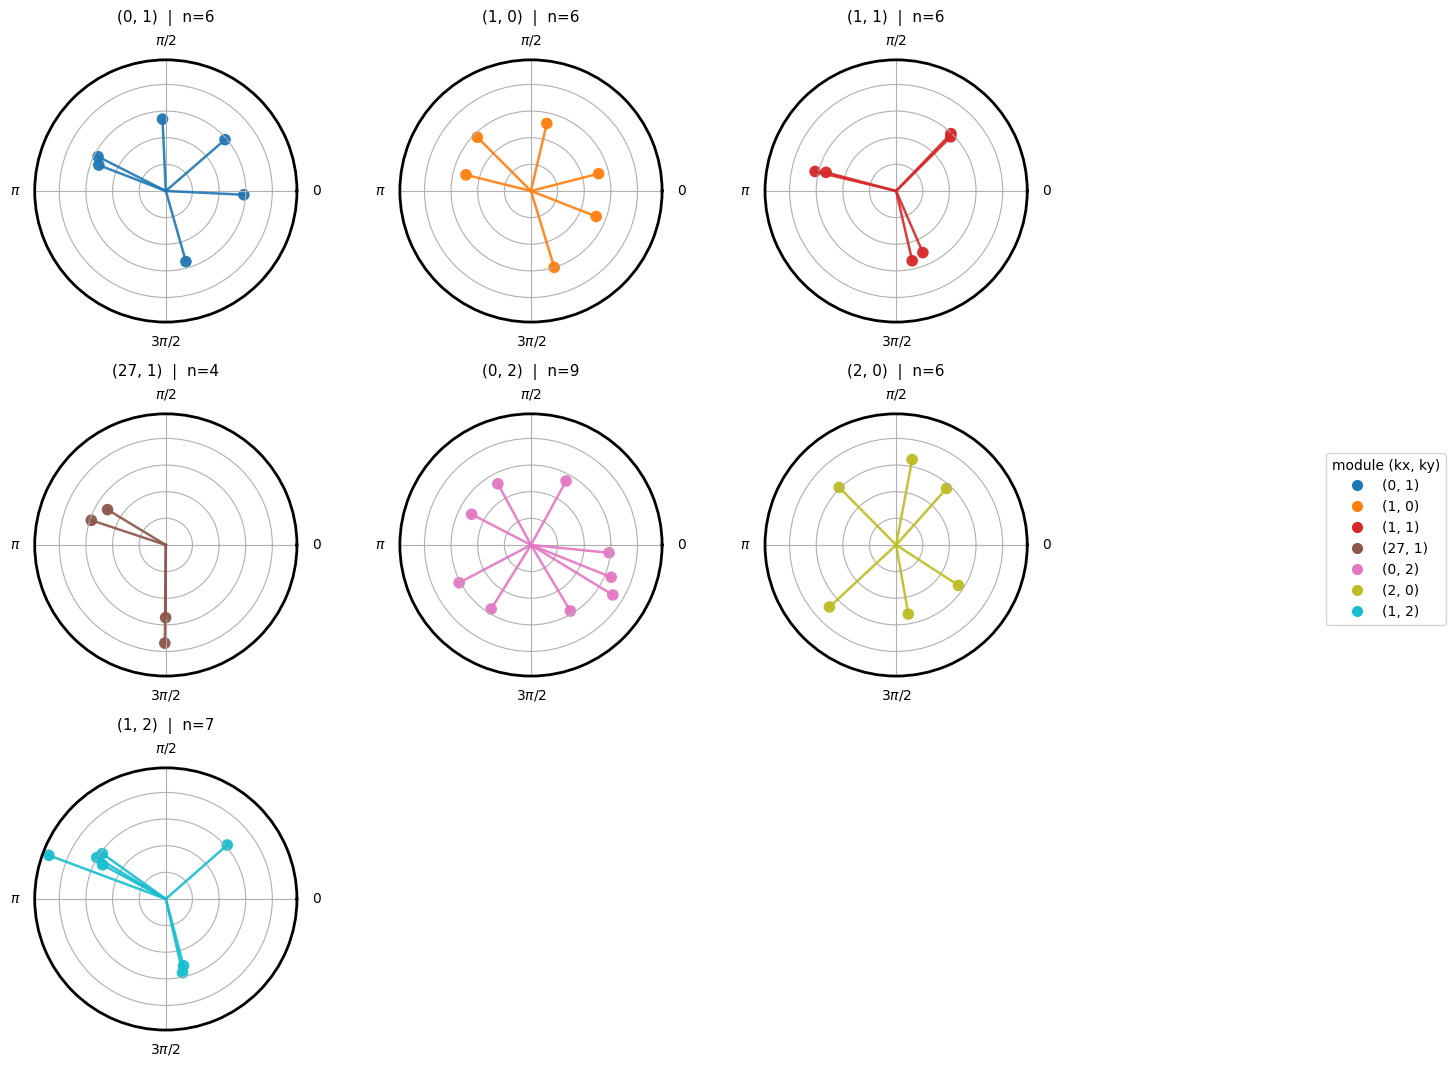

In [235]:
# One figure with a POLAR SUBPLOT per module (tracked (kx, ky)), excluding DEAD and DC-dominant.
# Uses the final checkpoint only (t = -1).

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

dead_thresh_l2 = 0.5  # absolute L2 threshold for "dead" neurons

# palette (one color per tracked freq)
if 'palette' not in locals() or len(palette) != len(tracked_freqs):
    palette = plt.cm.tab10(np.linspace(0, 1, len(tracked_freqs)))

# ---------- helpers ----------
def squareish_grid(n):
    c = int(np.ceil(np.sqrt(n)))
    r = int(np.ceil(n / c))
    return r, c

def tracked_power_from_fft2(P, kx, ky, p1, p2):
    i0, j0 = kx % p1, ky % p2
    i1, j1 = (-kx) % p1, (-ky) % p2
    return P[i0, j0] if (i0, j0) == (i1, j1) else P[i0, j0] + P[i1, j1]

def canonical_bin(kx, ky, p1, p2):
    i, j = kx % p1, ky % p2
    if j > p2 - j:                       # prefer upper half-plane in ky
        i, j = (-kx) % p1, (-ky) % p2
    if j == 0 or (p2 % 2 == 0 and j == p2 // 2):  # ky edge: fold kx too
        if i > p1 - i:
            i = (-kx) % p1
    return i, j

def phase_at_2d_bin(m2d, kx, ky, p1, p2):
    F = np.fft.fft2(m2d)
    i, j = canonical_bin(kx, ky, p1, p2)
    return float(np.angle(F[i, j]))  # [-pi, pi]

# ---------- final step only ----------
sd = param_hist_2d[-1]
Wo = sd["W_out"].detach().cpu().numpy()      # (p1*p2, H) or (H, p1*p2)
if Wo.shape[0] == p1 * p2:
    W = Wo.T
elif Wo.shape[1] == p1 * p2:
    W = Wo
else:
    raise ValueError(f"W_o has incompatible shape {Wo.shape}; expected one dim == p1*p2={p1*p2}")
H, D = W.shape
assert D == p1 * p2

# per-neuron dominant tracked freq, phase, radius
dom_idx = np.full(H, -1, dtype=int)
phase   = np.full(H, np.nan, dtype=float)
radius  = np.linalg.norm(W, axis=1)
dead    = radius < dead_thresh_l2

for i in range(H):
    if dead[i]:
        continue
    m = W[i].reshape(p1, p2)
    F = np.fft.fft2(m); P = (F.conj() * F).real
    tp = [tracked_power_from_fft2(P, kx, ky, p1, p2) for (kx, ky) in tracked_freqs]
    j = int(np.argmax(tp))
    kx, ky = tracked_freqs[j]
    if (kx, ky) == (0, 0):  # DC has undefined phase → skip
        continue
    dom_idx[i] = j
    phase[i] = phase_at_2d_bin(m, kx, ky, p1, p2)

# ---------- build module masks (exclude empty and DEAD) ----------
valid = (~dead) & np.isfinite(phase)
modules = [(j, (valid & (dom_idx == j))) for j in range(len(tracked_freqs))]
modules = [(j, msk) for (j, msk) in modules if np.any(msk)]   # keep non-empty modules only

if len(modules) == 0:
    print("No non-dead, non-DC neurons found for any tracked module.")
else:
    # global radial limit for comparability across subplots
    rmax_global = max(float(radius[msk].max()) for _, msk in modules)

    R, C = squareish_grid(len(modules))
    fig, axes = plt.subplots(R, C, figsize=(3.8*C + 3.0, 4.2*R), subplot_kw={"projection": "polar"})
    axes = np.atleast_1d(axes).ravel()

    for ax, (j, msk) in zip(axes, modules):
        th = phase[msk]
        r  = radius[msk]

        # sticks + markers
        for th_i, r_i in zip(th, r):
            ax.plot([th_i, th_i], [0.0, r_i], color=palette[j], linewidth=1.8, alpha=0.9)
        ax.scatter(th, r, s=70, color=palette[j], edgecolors='none', alpha=0.95)

        # styling
        ax.set_title(f"{tracked_freqs[j]}  |  n={np.count_nonzero(msk)}", fontsize=11, pad=8)
        ax.set_theta_zero_location("E")
        ax.set_thetagrids(
            np.arange(0, 360, 90),  # sparser grid to reduce clutter
            ["0", r"$\pi/2$", r"$\pi$", r"$3\pi/2$"]
        )
        ax.set_yticklabels([])
        ax.spines["polar"].set_linewidth(2)
        ax.set_rlim(0, 1.05 * rmax_global if rmax_global > 0 else 1.0)

    # hide any unused axes
    for ax in axes[len(modules):]:
        ax.set_visible(False)

    # legend with only shown modules, outside on the right
    handles = [Line2D([0],[0], marker='o', linestyle='', color=palette[j],
                      label=f"{tracked_freqs[j]}", markersize=7)
               for (j, _) in modules]
    fig.legend(handles=handles, loc='center left', bbox_to_anchor=(1.02, 0.5),
               frameon=True, title="module (kx, ky)")

    fig.subplots_adjust(right=0.82, wspace=0.35, hspace=0.35)
    # plt.savefig("phase_polar_modules_grid.png", bbox_inches="tight", dpi=170)
    plt.show()

## Activation Plot

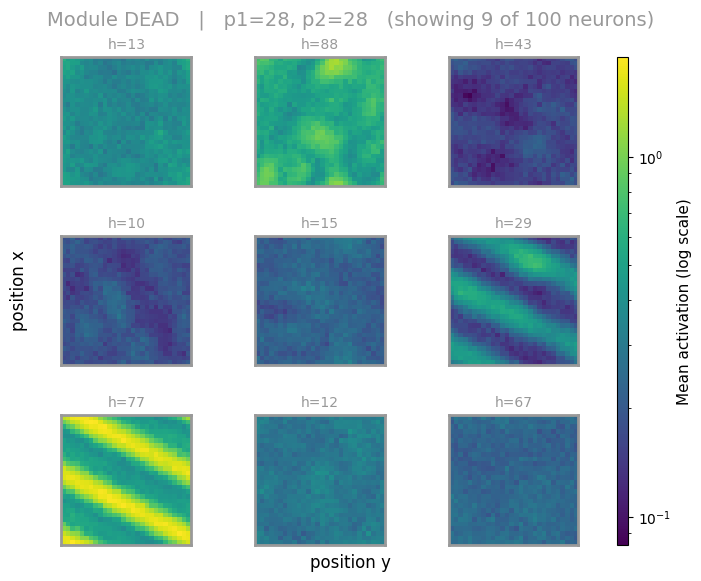

In [183]:
paths_xy = sequence_to_paths_xy(sequence_xy, p1, p2)

# ========= Config =========
dead_l2_thresh = 1.0             # absolute L2 threshold (on W_o rows) for DEAD
if 'palette' not in locals() or len(palette) != len(tracked_freqs):
    palette = plt.cm.tab10(np.linspace(0, 1, len(tracked_freqs)))
dead_color = (0.6, 0.6, 0.6, 1.0)

tile_w, tile_h = 1.9, 1.9         # inches per neuron tile
border_lw      = 2.0
title_fs       = 14
cmap_heat      = "viridis"
max_neurons_per_module = 9        # 3x3 grid

# ========= Unroll hidden activations (bias-free quadratic RNN) =========
@torch.no_grad()
def unroll_hidden_batch_quadratic_no_bias(x_seq_t, rnn, batch_size=4096):
    """
    For QuadraticRNN:
      h0 = template @ W_in^T
      h_t = (W_mix h_{t-1} + W_drive x_t)^2  for t = 0..k-1
    Returns: H_all of shape (N, k, d) with the hidden AFTER each update t.
    """
    N, K, p = x_seq_t.shape
    d = rnn.W_mix.shape[0]
    H_all = torch.empty((N, K, d), device=x_seq_t.device, dtype=rnn.W_mix.dtype)

    # template -> (p,) then h0_vec -> (d,)
    tmpl = rnn.template
    if tmpl.dim() == 2 and tmpl.size(0) == 1:
        tmpl = tmpl.squeeze(0)
    h0_vec = tmpl @ rnn.W_in.T  # (d,)

    for start in range(0, N, batch_size):
        end = min(N, start + batch_size)
        xb = x_seq_t[start:end]                 # (B, K, p)
        B = xb.size(0)

        # expand h0 across the batch
        h = h0_vec.expand(B, -1).contiguous()   # (B, d)

        for t in range(0, K):
            xt = xb[:, t, :]                    # (B, p)
            pre = (h @ rnn.W_mix.T) + (xt @ rnn.W_drive.T)
            h = pre.pow(2)
            H_all[start:end, t, :] = h

    return H_all


# ========= Collect activations =========
if 'device' not in locals():
    device = next(rnn_2d.parameters()).device
X_seq_t = torch.tensor(X_seq_2d, dtype=torch.float32, device=device)
rnn_2d.to(device).eval()
with torch.no_grad():
    H_all = unroll_hidden_batch_quadratic_no_bias(X_seq_t, rnn_2d, batch_size=4096)  # (N, k, H)

# ========= Prep numpy views =========
H_all_np  = H_all.detach().cpu().numpy()                  # (N, k, H)
pos_xy    = paths_xy.reshape(-1, 2)                       # (N*k, 2)
pos_lin   = pos_xy[:, 0] * p2 + pos_xy[:, 1]              # linearized index in [0..p1*p2-1]
acts_flat = H_all_np.reshape(-1, H_all_np.shape[2])       # (N*k, H)

# Precompute counts per 2D position (shared by all neurons)
counts_lin = np.bincount(pos_lin, minlength=p1*p2).astype(np.int64)
counts     = counts_lin.reshape(p1, p2)

# ========= Module assignment from W_o using tracked 2D frequencies =========
Wo = rnn_2d.W_out.detach().cpu().numpy()   # (p1*p2, H)
W  = Wo.T                                 # (H, p1*p2)
Hdim = W.shape[0]
l2_norm = np.linalg.norm(W, axis=1)
is_dead = (l2_norm < dead_l2_thresh)

def tracked_power_from_fft2(power2d, kx, ky, p1, p2):
    i0, j0 = kx % p1, ky % p2
    i1, j1 = (-kx) % p1, (-ky) % p2
    if (i0, j0) == (i1, j1):
        return power2d[i0, j0]
    return power2d[i0, j0] + power2d[i1, j1]

dom_idx = np.empty(Hdim, dtype=int)    # index into tracked_freqs
dom_pw  = np.empty(Hdim, dtype=float)
phase   = np.empty(Hdim, dtype=float)  # phase at representative (i0, j0)

for j in range(Hdim):
    m = W[j].reshape(p1, p2)
    F = np.fft.fft2(m)
    P = (F.conj() * F).real
    tp = [tracked_power_from_fft2(P, kx, ky, p1, p2) for (kx, ky) in tracked_freqs]
    jj = int(np.argmax(tp))
    dom_idx[j] = jj
    # phase at a consistent representative bin
    i0, j0 = tracked_freqs[jj][0] % p1, tracked_freqs[jj][1] % p2
    phase[j]  = np.angle(F[i0, j0])
    dom_pw[j] = tp[jj]

# Assign module id (DEAD = -1)
module_id = np.where(is_dead, -1, dom_idx)

# Group neurons by module (dead last)
groups = {}
for nid, mid in enumerate(module_id):
    groups.setdefault(int(mid), []).append(nid)

freq_keys    = [i for i in range(len(tracked_freqs)) if i in groups]  # keep tracked order
ordered_mods = freq_keys + ([-1] if -1 in groups else [])

# ========= Pick up to 9 neurons/module (stable) =========
def pick_neurons_for_module(m, max_neurons=9):
    idxs = groups[m]
    if m == -1:
        # DEAD: weakest first
        idxs = sorted(idxs, key=lambda i: l2_norm[i])
    else:
        # sort by (phase mod 2π, then -dom_power) for reproducibility
        idxs = sorted(idxs, key=lambda i: ((phase[i] + 2*np.pi) % (2*np.pi), -dom_pw[i]))
    return idxs[:min(max_neurons, len(idxs))]

picked = {m: pick_neurons_for_module(m, max_neurons_per_module) for m in ordered_mods}

# ========= Build mean activation map for a neuron =========
# Efficient: single bincount per neuron; reuse global counts
def mean_activation_map_for_neuron(nid: int) -> np.ndarray:
    sums_lin = np.bincount(pos_lin, weights=acts_flat[:, nid], minlength=p1*p2)
    sums     = sums_lin.reshape(p1, p2)
    return sums / np.maximum(counts, 1)   # avoid div-by-zero

# ========= Plot: one 3×3 figure per module (colorbar on far right) =========
for m in ordered_mods:
    nids = picked[m]
    if len(nids) == 0:
        continue

    mlabel = ("DEAD" if m == -1 else tracked_freqs[m])
    mcolor = (dead_color if m == -1 else palette[m])
    safe   = str(mlabel).replace("(", "").replace(")", "").replace(",", "_").replace(" ", "")

    # Compute maps for this module
    maps = [mean_activation_map_for_neuron(nid) for nid in nids]

    # ---- LOG SCALE: choose vmin as smallest positive, vmax as max ----
    vmax = max(float(mp.max()) for mp in maps)
    posmins = [float(mp[mp > 0].min()) for mp in maps if np.any(mp > 0)]
    use_log = (len(posmins) > 0) and (vmax > 0)
    if use_log:
        vmin_pos = min(posmins)
        norm = LogNorm(vmin=vmin_pos, vmax=vmax)
    else:
        # fallback to linear if no positive values
        vmin = min(float(mp.min()) for mp in maps)
        norm = None  # linear

    nrows, ncols = 3, 3
    fig = plt.figure(figsize=(ncols * tile_w + 1.2, nrows * tile_h), constrained_layout=True)
    gs = fig.add_gridspec(nrows=nrows, ncols=ncols + 1, width_ratios=[1, 1, 1, 0.06], wspace=0.08, hspace=0.08)

    axes_r, last_im = [], None
    for r in range(nrows):
        for c in range(ncols):
            ax = fig.add_subplot(gs[r, c]); axes_r.append(ax)

    for i, ax in enumerate(axes_r):
        if i < len(nids):
            if use_log:
                im = ax.imshow(maps[i], norm=norm, origin="lower", aspect="equal", cmap=cmap_heat)
                # Optional: make zeros clearly visible
                # im.cmap.set_under('white')
            else:
                im = ax.imshow(maps[i], vmin=vmin, vmax=vmax, origin="lower", aspect="equal", cmap=cmap_heat)
            last_im = im
            ax.set_title(f"h={nids[i]}", fontsize=10, color=mcolor)
            for sp in ax.spines.values():
                sp.set_edgecolor(mcolor); sp.set_linewidth(border_lw)
        else:
            ax.axis("off")
        ax.set_xticks([]); ax.set_yticks([])

    # Colorbar on the far right
    cax = fig.add_subplot(gs[:, -1])
    if last_im is not None:
        cbar = fig.colorbar(last_im, cax=cax)
        cbar.set_label("Mean activation (log scale)" if use_log else "Mean activation", fontsize=11)
        # Optional: nice log ticks
        # if use_log:
        #     import numpy as np
        #     ticks = np.logspace(np.log10(vmin_pos), np.log10(vmax), num=5)
        #     cbar.set_ticks(ticks)

    fig.suptitle(
        f"Module {mlabel}   |   p1={p1}, p2={p2}   (showing {len(nids)} of {len(groups[m])} neurons)",
        fontsize=title_fs, color=mcolor
    )
    fig.supxlabel("position y", fontsize=12)
    fig.supylabel("position x", fontsize=12)

    plt.savefig(f"activations2D_module_{safe}_3x3.png", bbox_inches="tight", dpi=170)
    plt.show()